# 第5章 大規模言語モデルのファインチューニング

**注意**
2023/7/28現在、MARC-jaのデータセットの配布元のリンクが切れており、書籍上の5.2、5.3、5.5.4節に掲載されているコードにおいて、データセット読み込みの箇所でエラーが出る状態です。このため、MARC-jaと同様の感情分析のデータセットであるWRIMEを用いた同様のノートブックを[こちら](https://colab.research.google.com/github/ghmagazine/llm-book/blob/main/chapter5/5-2-sentiment-analysis-finetuning-wrime.ipynb)に用意しましたので適宜ご参照ください。

## 5.2 感情分析モデルの実装

### 5.2.1 環境の準備

In [1]:
!pip install transformers[ja,torch] datasets matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 33.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 31.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.0/698.0 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

### 5.2.2 データセットの準備

In [11]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/JGLUEのリポジトリから
# MARC-jaのデータを読み込む
train_dataset = load_dataset(
    "llm-book/wrime-sentiment",
    #"llm-book/JGLUE",
    #name="MARC-ja",
    split="train"
)
valid_dataset = load_dataset(
    "llm-book/wrime-sentiment",
    #"llm-book/JGLUE",
    #name="MARC-ja",
    split="validation"
)
# pprintで見やすく表示する
pprint(train_dataset[0])

{'datetime': '2012/7/31 23:48',
 'label': 1,
 'sentence': 'ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…',
 'user_id': 1}


In [12]:
pprint(train_dataset.features)

{'datetime': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'negative'], id=None),
 'sentence': Value(dtype='string', id=None),
 'user_id': Value(dtype='int64', id=None)}


### 5.2.3 トークナイザ

In [13]:
from transformers import AutoTokenizer

# Hugging Face Hub上のモデル名を指定
model_name = "cl-tohoku/bert-base-japanese-v3"
# モデル名からトークナイザを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)
# トークナイザのクラス名を確認
print(type(tokenizer).__name__)

tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

BertJapaneseTokenizer


In [14]:
tokenizer.tokenize("これはテストです。")

['これ', 'は', 'テスト', 'です', '。']

In [15]:
encoded_input = tokenizer("これはテストです。")
# 出力されたオブジェクトのクラスを表示
print(type(encoded_input).__name__)

BatchEncoding


In [16]:
pprint(encoded_input)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [2, 12538, 465, 14985, 13037, 385, 3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


In [17]:
tokenizer.convert_ids_to_tokens(encoded_input["input_ids"])

['[CLS]', 'これ', 'は', 'テスト', 'です', '。', '[SEP]']

### 5.2.4 データセット統計の可視化

100%|██████████| 20149/20149 [00:05<00:00, 3864.21it/s]


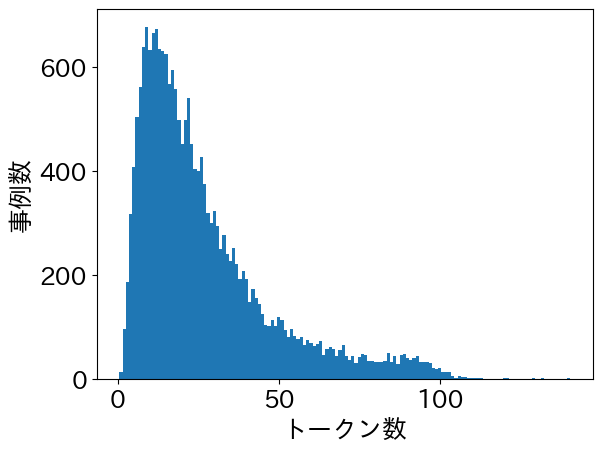

100%|██████████| 1608/1608 [00:00<00:00, 2748.24it/s]


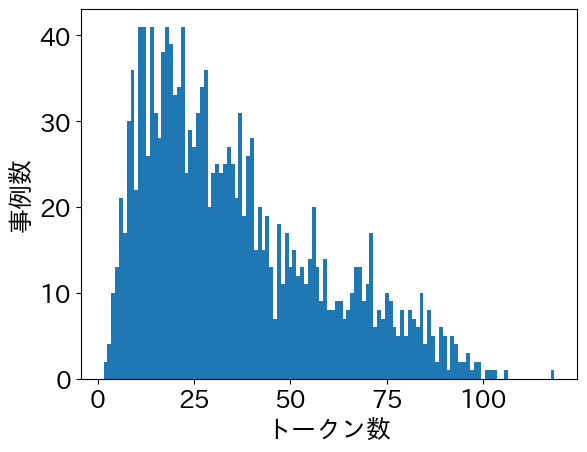

In [18]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["sentence"]))
        length_counter[length] += 1
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()

visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

In [19]:
for data in valid_dataset:
    if len(tokenizer.tokenize(data["sentence"])) < 10:
        pprint(data)

{'datetime': '2020/5/15 17:35',
 'label': 1,
 'sentence': 'よくわからない連携。',
 'user_id': 26}
{'datetime': '2020/5/15 17:47',
 'label': 1,
 'sentence': 'この3年が無駄になった。',
 'user_id': 26}
{'datetime': '2020/5/15 17:48',
 'label': 1,
 'sentence': '空気を読んでなくて。',
 'user_id': 26}
{'datetime': '2020/5/15 17:52',
 'label': 1,
 'sentence': 'っていうか、英語の聞きすぎ',
 'user_id': 26}
{'datetime': '2020/5/18 16:31',
 'label': 0,
 'sentence': '明日は楽しみかも。',
 'user_id': 26}
{'datetime': '2020/5/19 11:55',
 'label': 1,
 'sentence': '今日は誤字だらけ。',
 'user_id': 26}
{'datetime': '2020/5/21 8:29',
 'label': 0,
 'sentence': 'SUNがいいなと思った。',
 'user_id': 26}
{'datetime': '2020/5/5 6:50',
 'label': 0,
 'sentence': 'わさび醤油、結構合う。',
 'user_id': 28}
{'datetime': '2020/5/6 6:13',
 'label': 1,
 'sentence': '朝から本当に腹立たしい。',
 'user_id': 28}
{'datetime': '2020/5/6 6:27',
 'label': 1,
 'sentence': 'しかも本人は反省の色なし',
 'user_id': 28}
{'datetime': '2020/5/6 8:18', 'label': 1, 'sentence': '書けない', 'user_id': 28}
{'datetime': '2020/3/2 19:32',
 'label':

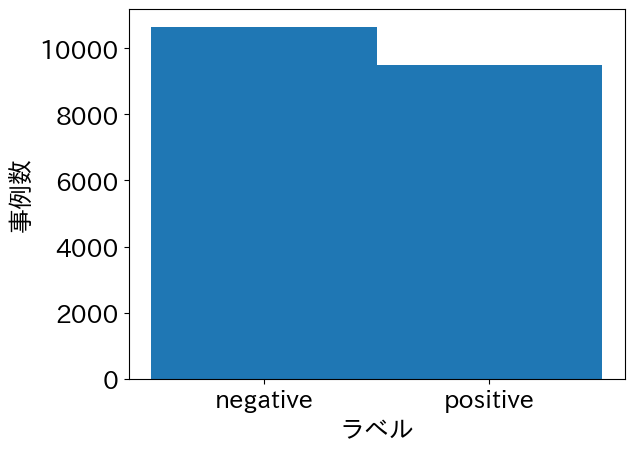

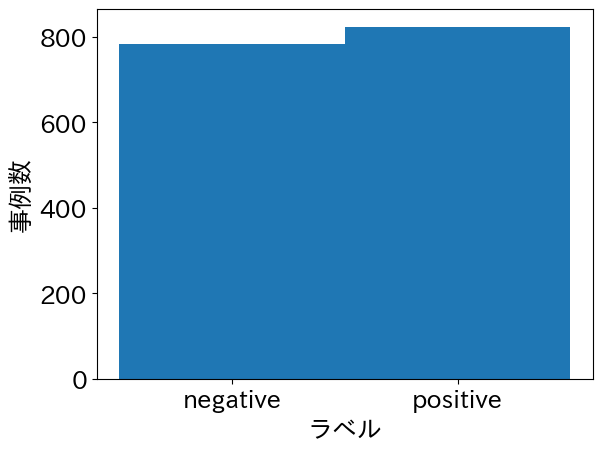

In [20]:
def visualize_labels(dataset: Dataset):
    """データセット中のラベル分布をグラフとして描画"""
    # データセット中のラベルの数を数える
    label_counter = Counter()
    for data in dataset:
        label_id = data["label"]
        label_name = dataset.features["label"].names[label_id]
        label_counter[label_name] += 1
    # label_counterを棒グラフとして描画する
    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel("ラベル")
    plt.ylabel("事例数")
    plt.show()

visualize_labels(train_dataset)
visualize_labels(valid_dataset)

### 5.2.5 データセットの前処理

In [ ]:
from transformers import BatchEncoding

def preprocess_text_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文書分類の事例のテキストをトークナイズし、IDに変換"""
    encoded_example = tokenizer(example["sentence"], max_length=512)
    # モデルの入力引数である"labels"をキーとして格納する
    encoded_example["labels"] = example["label"]
    return encoded_example

In [ ]:
encoded_train_dataset = train_dataset.map(
    preprocess_text_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_classification,
    remove_columns=valid_dataset.column_names,
)

Map:   0%|          | 0/187528 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/5654 [00:00<?, ? examples/s]

In [ ]:
print(encoded_train_dataset[0])

{'input_ids': [2, 13204, 23886, 464, 2683, 461, 12538, 500, 481, 456, 15066, 457, 484, 913, 11226, 461, 12493, 456, 14281, 458, 2391, 18351, 456, 384, 2702, 34, 2002, 385, 21709, 456, 14982, 458, 601, 2023, 14120, 449, 430, 384, 15171, 5986, 7126, 456, 437, 12581, 449, 385, 37, 2002, 1039, 461, 484, 384, 23886, 464, 23, 458, 12737, 456, 484, 14087, 13037, 430, 24, 12566, 464, 15637, 461, 19219, 13123, 384, 12538, 465, 23845, 16, 458, 14120, 456, 384, 16050, 457, 484, 742, 2023, 484, 13619, 461, 13497, 12727, 384, 1781, 457, 484, 5538, 456, 12727, 441, 449, 13325, 457, 384, 15171, 14563, 12519, 461, 21709, 456, 24003, 12581, 449, 385, 385, 385, 12499, 12611, 384, 15171, 34, 1423, 13929, 441, 456, 12995, 385, 458, 7446, 7446, 457, 12517, 13819, 384, 5640, 429, 464, 2149, 464, 17481, 461, 12493, 456, 14982, 7203, 466, 458, 16584, 13819, 385, 14902, 464, 2790, 484, 13588, 13037, 385, 420, 7053, 384, 12731, 484, 15581, 8793, 7349, 15750, 500, 27774, 13030, 385, 13125, 484, 441, 13030, 430, 

### 5.2.6 ミニバッチ構築

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 175]),
 'input_ids': torch.Size([4, 175]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 175])}


### 5.2.7 モデルの準備

In [ ]:
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,  # ラベル名からIDへの対応を指定
    id2label=id2label,  # IDからラベル名への対応を指定
)
print(type(model).__name__)

# パラメータをメモリ上に隣接した形で配置
# これを実行しない場合、モデルの保存でエラーになることがある
for param in model.parameters():
    param.data = param.data.contiguous()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v3 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

BertForSequenceClassification


In [ ]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(0.4402, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.5469, -0.2591],
        [ 0.3565,  0.0415],
        [ 0.1228, -0.5284],
        [ 0.5843, -0.0540]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


### 5.2.8 訓練の実行

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_marc_ja",  # 結果の保存フォルダ
    per_device_train_batch_size=32,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    learning_rate=2e-5,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=3,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
    report_to="none",  # 外部ツールへのログを無効化
)

In [ ]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測ラベルと正解ラベルから正解率を計算"""
    predictions, labels = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.137000,0.101480,0.965157
2,0.077200,0.140027,0.960559
3,0.043200,0.176728,0.961089


TrainOutput(global_step=17583, training_loss=0.08579717433365147, metrics={'train_runtime': 11712.7501, 'train_samples_per_second': 48.032, 'train_steps_per_second': 1.501, 'total_flos': 8.623769472692784e+16, 'train_loss': 0.08579717433365147, 'epoch': 3.0})

### 5.2.9 訓練後のモデルの評価

In [ ]:
# 検証セットでモデルを評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.9651574106827026,
 'eval_loss': 0.10147950798273087,
 'eval_runtime': 39.2055,
 'eval_samples_per_second': 144.214,
 'eval_steps_per_second': 4.515}


### 5.2.10 モデルの保存

Google Driveへの保存

In [ ]:
# Googleドライブをマウントする
from google.colab import drive

drive.mount("drive")

In [ ]:
# 保存されたモデルをGoogleドライブのフォルダにコピーする
!mkdir -p drive/MyDrive/llm-book
!cp -r output_marc_ja drive/MyDrive/llm-book

Hugging Face Hubへの保存

In [ ]:
from huggingface_hub import login

login()

# Hugging Face Hubのリポジトリ名
# "YOUR-ACCOUNT"は自らのユーザ名に置き換えてください
repo_name = "YOUR-ACCOUNT/bert-base-japanese-v3-marc_ja"
# トークナイザとモデルをアップロード
tokenizer.push_to_hub(repo_name)
model.push_to_hub(repo_name)